In [41]:
import numpy as np
import pathlib as pl
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from copy import copy
import retroBO_analysis_functions as fns
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('mystyle.mplstyle')

inch_conversion = 1/25.4
page_width = 142.4 *inch_conversion
column_width = 67.2* inch_conversion

# Notebook for Plotting Retrospective Bayesian Optimisation Results

This notebook is for plotting the results of the retrospective Bayesian optimisation on the PCR data.

First specify the problem

In [42]:
param_name = 'r' # which parameters
save=False
params = ['r']
starting_points = ['centre', '0_point_start'] 
learning_types = ['learning_many', 'learning_1']

Load the results for the learning many case

In [43]:
many_dfs = {}
path_name_ =  pl.Path.home() / f'Results/RetroBO'

initial_surfaces = ['FP004-RP004-EvaGreen', 'FP002-RP002x-Probe']
many_dfs[f'centre learning many'] = fns.load_retroBO_data(test_name=f'many_{param_name}_centre_True',
                                                          restarts=restarts, initial_surfaces=initial_surfaces)
many_dfs[f'0_point_start learning many'] = fns.load_retroBO_data(test_name=f'many_{param_name}_0_point_start_True',
                                                                 restarts=restarts, initial_surfaces=initial_surfaces)

load the results for learning one at a time

In [44]:
learning_surfaces = ['FP004-RP004-Probe', 'FP001-RP001x-EvaGreen', 'FP002-RP002x-EvaGreen',
                'FP001-RP001x-Probe', 'FP005-FP001-Probe', 'RP001x-FP002-Probe',
                'RP002x-FP005-Probe', 'FP005-FP004-EvaGreen', 'RP002x-FP002-EvaGreen',
                'FP001-RP004-EvaGreen', 'FP002-RP004-EvaGreen', 'FP004-FP005-Probe',
                'RP008x-FP005-Probe', 'FP005-FP001-EvaGreen', 'RP002x-FP004-EvaGreen',
                'RP008x-FP001-EvaGreen']

one_from_many_dfs = {}
for starting_point in starting_points:
    results_dfs = {}
    initial_surfaces_dfs = {}
    for learning_surface in learning_surfaces:
        test_name = f'one_from_many_{learning_surface}_{param_name}_{starting_point}_True'
        initial_surfaces = fns.get_initial_surfaces_one(test_name, learning_surface)
        results_df = fns.load_retroBO_data(test_name, restarts, initial_surfaces)

        if results_df is not None:
            # avg_max = int(results_df.loc[results_df['model'] == 'avg', 'iteration' ].to_numpy().max())
            # results_df = results_df.loc[results_df['iteration'] <= avg_max]
            results_dfs[learning_surface] = results_df

        initial_surfaces_dfs[learning_surface] = initial_surfaces
    results_df = pd.concat(results_dfs.values())
    one_from_many_dfs[f'{starting_point} learning 1'] = results_df

In [45]:
one_from_many_dfs[f'0_point_start learning 1']['iteration'] = one_from_many_dfs[f'0_point_start learning 1']['iteration'] - 1
many_dfs[f'0_point_start learning many']['iteration'] = many_dfs[f'0_point_start learning many']['iteration'] - 1

create dict of the results dataframes

In [46]:
res_dfs = one_from_many_dfs
res_dfs.update(many_dfs)

In [47]:
res_dfs2 = {}
res_dfs2[f'0_point_start_learning_1'] = res_dfs[f'0_point_start learning 1']
res_dfs2[f'0_point_start_learning_many'] = res_dfs[f'0_point_start learning many']
res_dfs2[f'centre_learning_1'] = res_dfs[f'centre learning 1']
res_dfs2[f'centre_learning_many'] = res_dfs[f'centre learning many']

In [48]:
results_path = pl.Path(os.getcwd()).parent / 'results'
for key, df in res_dfs2.items():
    df.to_csv(results_path /f'constrained_bayes_opt_{key}.csv')

In [49]:
res_dfs = {}
results_path = pl.Path(os.getcwd()).parent / 'results'
for key in ['centre_learning_1', '0_point_start_learning_1',
                  'centre_learning_many', '0_point_start_learning_many']:
    res_dfs[key] = pd.read_csv(results_path /f'constrained_bayes_opt_{key}.csv', index_col=0)

Check what data is missing
If necessary, see which seeds are missing data:

In [50]:
for key, df in res_dfs.items():
    print(key)
    counts_df = pd.DataFrame(columns=res_dfs[f'centre_learning_many']['PrimerPairReporter'].unique())
    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[df['PrimerPairReporter'] == ppr][['BP', 'GC', 'seed']].drop_duplicates()
        counts = df_.value_counts('seed').to_frame().sort_values(by='seed')
        counts_df[ppr] = df_.value_counts('seed').to_frame().sort_values(by='seed')
        # seeds_df[key][ppr] = len(df_['seed'].unique())
    print(counts_df.T.to_string())

centre_learning_1
seed                   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
FP001-RP001x-EvaGreen  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
FP002-RP002x-EvaGreen  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
FP005-FP001-Probe       8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
RP001x-FP002-Probe     19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19
RP002x-FP005-Probe      8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP005-FP004-EvaGreen    8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP004-RP004-Probe      47  49  49  47  49  49  53  46  49  46  47  49  38  47  41  47  47  46  39  47  53  47  46  43  47
RP002x

Calculate the regret

In [51]:
stzd = True
max_iter = 16

if len(params) >1:
    regret_metric = 'combined regret'
else:
    if param_name == 'r':
        regret_metric = 'regret r'
    elif param_name == 'm':
        regret_metric = 'regret m'

starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'Learning One\nat a Time'}
plot_minmax = True

regrets_all = {'learning_many':{}, 'learning_1':{}}
for i, learning_type in enumerate(learning_types): #, 'learning 1'
    for j, starting_point in enumerate(starting_points):
        df = res_dfs[f'{starting_point}_{learning_type}']
        best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
        regret_df_all = fns.calculate_regret(df, params, best_points, stzd=stzd)
        regret_df_all = regret_df_all[regret_df_all['iteration'] <=max_iter]
        regrets_all[learning_type][starting_point] = regret_df_all

In [52]:

cumulative_regrets = {'learning_many':{},
                      'learning_1':{}}
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regrets_all[learning_type][starting_point]

        if 'r' in params and 'm' in params:
            regret_names = ['combined regret', 'regret r', 'regret m']
        else:
            regret_names = [f'regret {param}' for param in params]

        # if learning_type == 'learning many':
        #     for seed in regret_df['seed'].unique():
        #         temp_df = regret_df[regret_df['seed'] == seed]
        #         if temp_df['iteration'].max() != max_iter:
        #             regret_df= regret_df[regret_df['seed'] != seed]

        regret_df = regret_df.sort_values('iteration')

        # calculate the cumulative minimum regret and cumulative sum of regret

        for model in regret_df['model'].unique():
            for seed in regret_df['seed'].unique():
                for ppr in regret_df['PrimerPairReporter'].unique():
                    for regret_name in regret_names:
                        regret_df.loc[
                            (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                        regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'] = \
                            regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), regret_name].cummin()
                        regret_df.loc[
                            (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                        regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cumsum'] = \
                            regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'].cumsum()
        cumulative_regrets[learning_type][starting_point] = regret_df

In [53]:
regret_metrics = {'learning_many':{}, 'learning_1':{}}
for i, learning_type in enumerate(learning_types): #, 'learning 1'
    for j, starting_point in enumerate(starting_points):
        regret_df = cumulative_regrets[learning_type][starting_point]

        i_max = regret_df['iteration'].max() #.loc[regret_df['model'] =='avg',

        for ppr in regret_df['PrimerPairReporter'].unique():

            ppr_imax = regret_df.loc[regret_df['PrimerPairReporter'] == ppr, 'iteration'].to_numpy().max()
            if ppr_imax == i_max:
                pass
            else:
                extra_rows = pd.concat([regret_df.loc[(regret_df['PrimerPairReporter'] == ppr)
                                                & (regret_df['iteration'] == ppr_imax)]] * int((i_max - ppr_imax)))
                extra_rows = extra_rows.sort_values(['model', 'seed'])
                if ppr_imax < (i_max - 1):
                    test = np.arange(ppr_imax + 1, i_max + 1).tolist() * int(len(extra_rows)/(i_max-ppr_imax))
                    extra_rows['iteration'] = np.arange(ppr_imax + 1, i_max + 1).tolist() \
                                              * int(len(extra_rows)/(i_max-ppr_imax))
                    regret_df = regret_df.append(extra_rows)
                elif ppr_imax == (i_max - 1):
                    extra_rows['iteration'] = i_max
                    regret_df = regret_df.append(extra_rows)
                else:
                    pass
        # if learning_type == 'learning many':
        df = regret_df.groupby(['model', 'iteration', 'seed']).mean().reset_index()

        df2 = df.groupby(['model', 'iteration']).mean().reset_index()
        df3 = df.groupby(['model', 'iteration']).median().reset_index()
        df4 = df.groupby(['model', 'iteration']).quantile(0.05).reset_index()
        df5 = df.groupby(['model', 'iteration']).quantile(0.95).reset_index()
        metrics = ['mean', 'median', 'min', 'max']

        dfs = [df2, df3, df4, df5]
        for i in range(len(dfs)):
            for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
                dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
            dfs[i] = dfs[i].drop(
                columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
                        + ['seed', 'index', 'initial_surface'] + regret_names)
        regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration'])
        regret_df = regret_df.merge(dfs[2], on=['model', 'iteration'])
        regret_df = regret_df.merge(dfs[3], on=['model', 'iteration'])

        # else:
        #
        #     # calculate the mean, min, and max of the cumulative minimum regret and cumulative sum of
        #     # regret across all seeds for each primer pair reporter
        #
        #     df4 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).mean().reset_index()
        #     df7 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).median().reset_index()
        #     df5 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).min().reset_index()
        #     df6 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).max().reset_index()
        #
        #     # create new dataframe which combines these metrics
        #
        #     metrics = ['mean', 'min', 'max', 'median']
        #     dfs = [df4, df5, df6, df7]
        #     for i in range(len(dfs)):
        #         for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
        #             dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
        #         dfs[i] = dfs[i].drop(
        #             columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
        #                     + ['seed', 'index', 'initial_surface'] + regret_names)
        #
        #     regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration', 'PrimerPairReporter'])
        #     regret_df = regret_df.merge(dfs[2], on=['model', 'iteration', 'PrimerPairReporter'])
        #     regret_df = regret_df.merge(dfs[3], on=['model', 'iteration', 'PrimerPairReporter'])


        regret_df = regret_df.groupby(['model', 'iteration']).mean().reset_index()
        regret_metrics[learning_type][starting_point] = regret_df


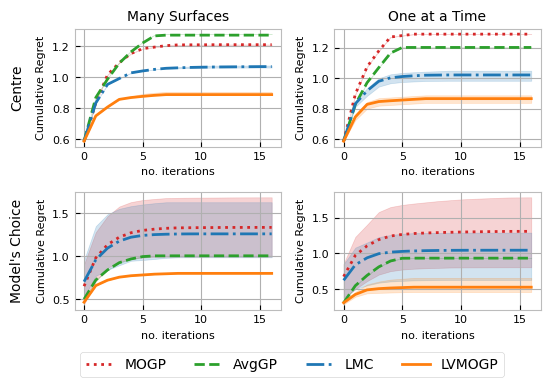

In [54]:
linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed' }
def get_colors():
    cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # cols = ['#E69F00', '#56B4E9', '#009E73', '#CC79A7',
    #               '#0072B2', '#D55E00', '#F0E442', '#000000', ]
    # cols = ['#7a0177', '#c51b8a','#f768a1',  '#fbb4b9']
    cols = ['#253494', '#2c7fb8','#41b6c4',  '#a1dab4']
    colors = {'lmc': cols[0], 'mo_indi': cols[3], 'lvm': cols[1], 'avg': cols[2]}
    return colors

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[page_width, page_width-2])
colors = fns.get_colors()
plot_minmax=True
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Many Surfaces', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}
for i, learning_type in enumerate(learning_types): #, 'learning 1'
    for j, starting_point in enumerate(starting_points):
        regret_df = regret_metrics[learning_type][starting_point]
        for model in ['mo_indi', 'avg', 'lmc', 'lvm']:
            df = regret_df[(regret_df['model'] == model) ].sort_values('iteration')
            if (j==0) & (i==0):
                label = labels[model]
            else:
                label = None
            axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                           color=colors[model], linestyle=linestyles[model])
            if plot_minmax:
                axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                       df[f'max {regret_metric} cumsum'],
                                       alpha=0.2, color=colors[model])
        axs[0, i].set_title(f'{learning_type_names[learning_type]}', fontsize=10)
        axs[j, i].set_ylabel(f'Cumulative Regret')
        axs[1, i].set_xlabel('no. iterations')
        axs[0, i].set_xlabel('no. iterations')

rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=10, ha='right', va='center', rotation=90)

        # plt.suptitle('Cumulative Regret')
        # axs[j, i].legend()

fig.legend(loc="lower center", ncols=4,
               bbox_to_anchor=(0.53, -0.08))
plt.tight_layout()
plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}.pdf', bbox_inches='tight')
plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}.svg', bbox_inches='tight')

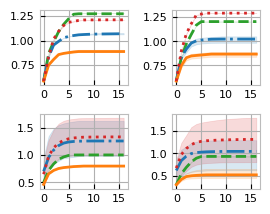

In [55]:

linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed' }

colors = fns.get_colors()
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s\nChoice'}
learning_type_names = {'learning many':'Many\nSurfaces', 'learning 1':'One at\na Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.5*page_width, 0.4*page_width])
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regret_metrics[learning_type][starting_point]
        for model in regret_df['model'].unique():
            df = regret_df[(regret_df['model'] == model)].sort_values('iteration')
            if (j==0) & (i==0):
                label = labels[model]
            else:
                label = None
            axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                           color=colors[model], linestyle=linestyles[model])
            if plot_minmax:
                axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                       df[f'max {regret_metric} cumsum'],
                                       alpha=0.17, color=colors[model])
        # axs[0, i].set_title(f'{learning_type_names[learning_type]}')
        # axs[j, i].set_ylabel(f'Cum. Regret')
        axs[j, i].set_xlabel(None)
        axs[j, 1].set_ylabel(None)
        axs[j, i].set_xticks([0, 5, 10, 15] )

# fig.legend(loc="lower center", ncols=2,
#                bbox_to_anchor=(0.5, -0.2))


# rows = [f'{row}' for row in starting_point_names.values()]
# for ax, row in zip(axs[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 10, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center', rotation=90)

        # plt.suptitle('Cumulative Regret')
        # axs[j, i].legend()
# plt.tight_layout()
# fig.supxlabel('no. iterations')
plt.subplots_adjust(hspace=0.4, wspace=0.4, left=None, bottom=0.18, right=None, top=1)
plt.tight_layout()
plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}_half_wlines.pdf', bbox_inches='tight')
plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}_half_wlines.svg', bbox_inches='tight')

In [56]:
win_dfs = {}
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):
        df = res_dfs[f'{starting_point}_{learning_type}']
        best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
        regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd)
        regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]
        win_df, win_df_totals = fns.get_win_counts(regret_df1, regret_metric)
        win_df_cum_regret, win_df_totals_cum_regret = fns.get_cum_regret_table(regret_df1, regret_name=regret_metric)
        win_dfs[learning_type + starting_point] = win_df
        print(learning_type, starting_point)
        print('first to zero')
        print(win_df_totals[['avg', 'mo_indi', 'lmc', 'lvm']])
        print('lowest cumulative regret')
        print(win_df_totals_cum_regret[['avg', 'mo_indi', 'lmc', 'lvm']])

learning_many centre
first to zero
   avg mo_indi  lmc  lvm
0  121     124  144  255
lowest cumulative regret
  avg mo_indi  lmc  lvm
0  80     182  140  197
learning_many 0_point_start
first to zero
   avg mo_indi lmc  lvm
0  119     107  97  147
lowest cumulative regret
  avg mo_indi lmc  lvm
0  94      85  83  117
learning_1 centre
first to zero
   avg mo_indi  lmc  lvm
0  140     140  156  215
lowest cumulative regret
   avg mo_indi  lmc  lvm
0  140     129  131  206
learning_1 0_point_start
first to zero
   avg mo_indi lmc  lvm
0  118      86  87  191
lowest cumulative regret
   avg mo_indi lmc  lvm
0  106      89  87  159


Average number of iterations to best best_points

In [57]:
import math

if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}
# for i, learning_type in enumerate(['learning many', 'learning 1']):
#     for j, starting_point in enumerate(starting_points):
for name, df in res_dfs.items():
    best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, constrained=False)
    # regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]

    df = regret_df1
    avg_iter_df = pd.DataFrame(columns=['PrimerPairReporter'] + list(df['model'].unique()))
    avg_iter_df['PrimerPairReporter'] = df['PrimerPairReporter'].unique()
    for ppr in df['PrimerPairReporter'].unique():
        zero_regret_dict = {model:[] for model in df['model'].unique()}
        for seed in range(1, 21):
            temp_df = df[(df['PrimerPairReporter'] == ppr) & (df['seed'] == seed)]
            if len(temp_df) < 1:
                pass
            else:
                for model in temp_df['model'].unique():
                    temp_1 = temp_df[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)]
                    temp_2 = temp_df[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.05)]
                    # temp_1 = temp_df.loc[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8), 'iteration']
                    # temp_2 = temp_df.loc[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.06)
                    #                      & (temp_df['regret m'] < 1e-8), 'iteration']
                    temp_3 = pd.concat([temp_1, temp_2])
                    zero_regret_dict[model].append(np.min(temp_3['iteration']))


                    # zero_regret_dict[model].append(np.min(
                    #     temp_df.loc[((temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)).all() or
                    #                 ((temp_df['model'] == model) & (temp_df['regret r'] <= 0.06)
                    #                & (temp_df['regret m'] < 1e-8)).all(), 'iteration']))
        # for model in temp_df['model'].unique():
            # zero_regret_dict[model] = [max_iter if math.isnan(x) else x for x in zero_regret_dict[model]]
        for model in df['model'].unique():
            if np.isnan(zero_regret_dict[model]).any():
                print(f'{name} {ppr} {model} has NaNs')
            avg_iter_df.loc[avg_iter_df['PrimerPairReporter'] == ppr, model] = np.mean(zero_regret_dict[model])
    print(name)
    print(avg_iter_df)
    print(avg_iter_df.mean())

centre_learning_1
       PrimerPairReporter  avg   lmc   lvm mo_indi
0   FP001-RP001x-EvaGreen  5.0   8.3   2.0     3.0
1      FP001-RP001x-Probe  5.0  6.45   8.0     7.0
2    FP001-RP004-EvaGreen  6.0   3.4  1.85     5.0
3   FP002-RP002x-EvaGreen  1.0   3.4   1.9     1.0
4    FP002-RP004-EvaGreen  1.0   1.0  1.05     1.0
5       FP004-FP005-Probe  1.0   5.0   3.0     4.0
6       FP004-RP004-Probe  2.0  2.25   2.0     3.0
7    FP005-FP001-EvaGreen  2.0   1.8   1.6     1.0
8       FP005-FP001-Probe  6.0   4.1  4.05     2.0
9    FP005-FP004-EvaGreen  0.0   0.0   0.0     0.0
10     RP001x-FP002-Probe  5.0   1.0   1.0     7.0
11  RP002x-FP002-EvaGreen  1.0   1.0   1.0     1.0
12  RP002x-FP004-EvaGreen  3.0  1.85   1.0     2.0
13     RP002x-FP005-Probe  0.0   0.0   0.0     0.0
14  RP008x-FP001-EvaGreen  5.0   2.0  2.95     5.0
15     RP008x-FP005-Probe  6.0   4.0   3.0     5.0
avg        3.062500
lmc        2.846875
lvm        2.150000
mo_indi    2.937500
dtype: float64
0_point_start_learni

In [58]:
first_regret_df = pd.DataFrame(columns=['model', 'starting point','learning type', 'mean', 'min', 'max'])
first_regret_df['model'] = ['avg', 'mo_indi', 'lmc', 'lvm'] * 4
first_regret_df['starting point'] = ['centre'] * 4 + ['0_point_start'] * 4 + ['centre'] * 4 + ['0_point_start'] * 4
first_regret_df['learning type'] = ['learning many'] * 8 + ['learning 1'] * 8
dfs = []

for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regret_metrics[learning_type][starting_point]
        for mod_name in regret_df['model'].unique():
            df_ = regret_df[(regret_df['model']==mod_name) & (regret_df['iteration'] == np.min(regret_df['iteration']))]
            new_df = pd.DataFrame(data=[[mod_name, starting_point, learning_type , df_['mean regret r cummin'].to_numpy()[0],
                                         df_['min regret r cummin'].to_numpy()[0],
                                         df_['max regret r cummin'].to_numpy()[0] ]],
                                  columns=['model', 'starting point','learning type', 'mean', 'min', 'max'])
            dfs.append(new_df)

first_regret_df = pd.concat(dfs, ignore_index=True)
print(first_regret_df.to_string())
print('lvm only:')
print(first_regret_df[first_regret_df['model']== 'lvm'].to_string())

      model starting point  learning type      mean       min       max
0       avg         centre  learning_many  0.587843  0.587843  0.587843
1       lmc         centre  learning_many  0.587843  0.587843  0.587843
2       lvm         centre  learning_many  0.587843  0.587843  0.587843
3   mo_indi         centre  learning_many  0.587843  0.587843  0.587843
4       avg  0_point_start  learning_many  0.498869  0.498869  0.498869
5       lmc  0_point_start  learning_many  0.703439  0.522551  0.953738
6       lvm  0_point_start  learning_many  0.463846  0.463846  0.463846
7   mo_indi  0_point_start  learning_many  0.650558  0.439144  0.905719
8       avg         centre     learning_1  0.587843  0.587843  0.587843
9       lmc         centre     learning_1  0.587843  0.587843  0.587843
10      lvm         centre     learning_1  0.587843  0.587843  0.587843
11  mo_indi         centre     learning_1  0.587843  0.587843  0.587843
12      avg  0_point_start     learning_1  0.307999  0.307999  0